In [96]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Q2 Regression

## Final Model

Following is the final model I get from linear regression using bacth gradient descent to find the optimization, it's pretty accurate on both training and test set so I don't bother using regularization. While it's true that from the weights/coefficients vector, some coefficients are either relatively too small or large, so it's worth a try to use lasso or ridge regression if needed.

Weight:
$\vec{w} = [-9.371, 11.263, -9.166, -0.464, 0.434, -0.409, 0.368, -0.067, -68.613, -0.109]$.

Feature:
$\vec{X} = [1, A, B, A^2, A^3, B^2, B^3, AB, A^2B, B^2A]^T$, while colomns in $\vec{X}$ should be normalized, except the intercept column.

The dependent varilable $C = \vec{w}\vec{X}$.

From following plot of actual 'C' against prediction, we can see it's almost aligned with the line $y=x$.

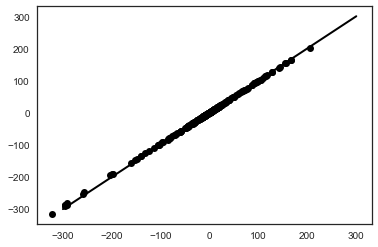

In [287]:
# Standardization for the whole dataset
sd = np.apply_along_axis(np.std, 0, da.drop(columns=['C']))
ret_train = da.drop(columns=['C']) - np.mean(da.drop(columns=['C']), axis=0)
for i in range(len(sd)):
    if sd[i] != 0:
        ret_train.iloc[:,i] = ret_train.iloc[:,i]/sd[i]
                         
whole_da = np.concatenate((np.array([np.ones(da.shape[0])]).T,ret_train),axis = 1)

# Truth - Prediction plot
plt.plot(w.dot(whole_da.T), da.C, 'o', color='black')
plt.plot([-300, 300], [-300, 300], color='k', linestyle='-', linewidth=2)

## Analytics details

In [240]:
da = pd.read_csv("Regression.csv", header=None) # read in dataset
da.columns = ['A', 'B', 'C']
da.head()

,A,B,C
0,0.490,-0.18,11.50
1,-1.410,-1.23,11.80
2,0.943,4.51,-3.24
3,3.570,5.07,-23.90
4,-1.700,6.91,-22.10


In [241]:
da[da.isnull().any(axis=1)]  # no missing data found

,A,B,C


In [242]:
da.describe() # the minimum of 'C' seems odd

,A,B,C
count,300.000000,300.000000,300.000000
mean,2.317009,2.013115,-41.564919
std,5.695248,2.998680,581.251021
min,-8.860000,-2.890000,-10000.000000
25%,-1.940000,-0.606250,-23.375000
50%,0.468500,1.935000,-3.090000
75%,7.042500,4.697500,16.300000
max,20.600000,7.000000,202.000000


# Remove outliers

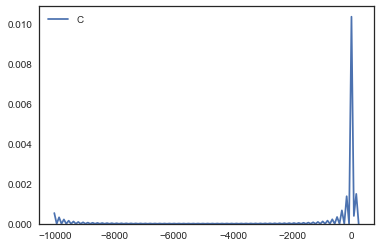

In [243]:
sns.kdeplot(da.C)

In [244]:
da[da.C < -2000]  # row with abnormal C value

,A,B,C
200,10.1,-2.24,-10000.0


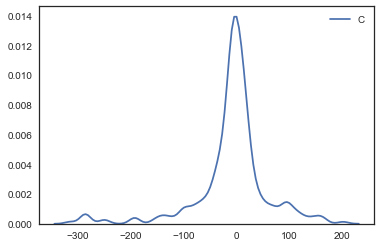

In [245]:
da = da.drop([200], axis=0).reset_index(drop=True) # drop the row
sns.kdeplot(da.C)

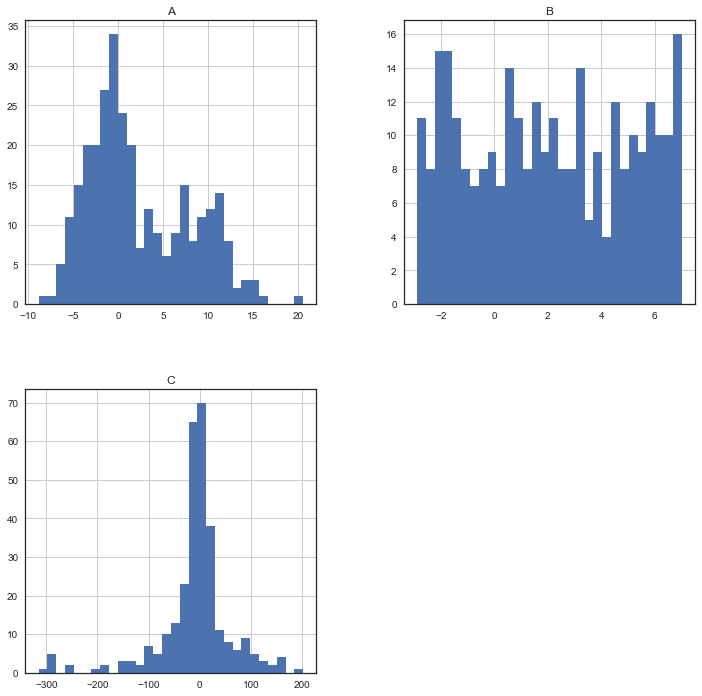

In [246]:
# Check the distribution of all columns
hist = da.hist(bins=30, figsize=(12, 12))

In [247]:
# Check the correlation matrix
corr = da.corr()
corr

,A,B,C
A,1.000000,-0.187059,0.010536
B,-0.187059,1.000000,-0.618516
C,0.010536,-0.618516,1.000000


## Batch Gradient Descent Implementation

In [249]:
# Standardization function
def normalization(train, test):
    sd = np.apply_along_axis(np.std, 0, train)
    ret_test = test - np.mean(train, axis=0)
    ret_train = train - np.mean(train, axis=0)
    for i in range(len(sd)):
        if sd[i] != 0:
            ret_train.iloc[:,i] = ret_train.iloc[:,i]/sd[i]
            ret_test.iloc[:,i] = ret_test.iloc[:,i]/sd[i]
    return ret_train, ret_test

In [250]:
# set learning rate and number of iteration
eta = 1e-1
iteration = 500

# weight update function
def update_b(weight, train, label, n):
    derv = 0
    for i in range(n):
        derv += (weight.dot(train[i])-label[i])*train[i]
    #print(derv)
    weight -= eta*derv/float(n)
    return weight

# Batch gradient descent function

def BGD(nepochs, s, X_tr, y_tr, X_ts, y_ts):
    # Initialization
    w = np.random.uniform(-0.1,0.1,size = s)
    tr_err = []
    ts_err = []
    n = X_tr.shape[0]
    
    for epoch in range(nepochs):
        w = update_b(w, X_tr, y_tr, n)
        tr_err.append(((w.dot(X_tr.T) - y_tr) ** 2).mean())
        ts_err.append(((w.dot(X_ts.T) - y_ts) ** 2).mean())

    # Get the plot
    plt.switch_backend("Agg")
    epoch = range(nepochs)
    plt.plot(epoch, tr_err, epoch, ts_err)
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend(['Train', 'Test'], loc='upper right')
    
    return w

From the scatter plot of dependent variable 'C', its distribution is not consistent with index changing, so we need to randomly split the original dataset into training and test set.

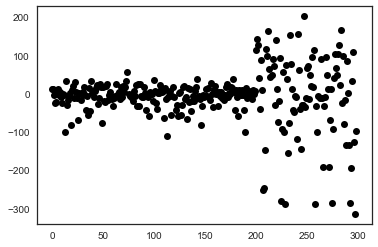

In [251]:
plt.plot(da.C, 'o', color='black')

In [252]:
# random sampling
train=da.sample(frac=0.7,random_state=200).reset_index(drop=True)
test=da.drop(train.index).reset_index(drop=True)

# Training set
X_train, y_train = train.drop(columns=['C']), train['C']
# Test set
X_test, y_test = test.drop(columns=['C']), test['C']

# data normalization
X_train, X_test = normalization(X_train, X_test)
# add intercept column
X_train = np.concatenate((np.array([np.ones(X_train.shape[0])]).T,X_train),axis = 1)
X_test = np.concatenate((np.array([np.ones(X_test.shape[0])]).T,X_test),axis = 1)

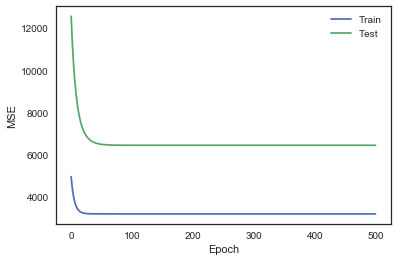

In [253]:
w = BGD(iteration, 3, X_train, y_train, X_test, y_test) # with training/test error plot

#### From "true value - prediction" plot for training set, the relation seems to be showing the pattern of polynomial.

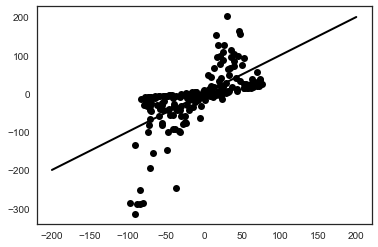

In [255]:
plt.plot(w.dot(X_train.T), y_train, 'o', color='black')
plt.plot([-200, 200], [-200, 200], color='k', linestyle='-', linewidth=2)

#### Not surprising that it performs really bad on test set.

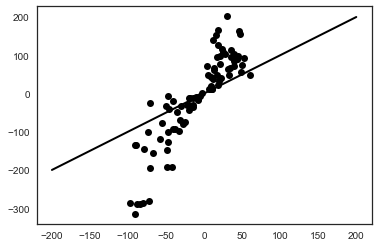

In [256]:
plt.plot(w.dot(X_test.T), y_test, 'o', color='black')
plt.plot([-200, 200], [-200, 200], color='k', linestyle='-', linewidth=2)

#### To add features regarding polynomial function, I'm tring to generate new columns which contribute to (A+B)^3, and run the linear regression again.

In [257]:
da['A2'] = da.A * da.A
da['A3'] = da.A * da.A2
da['B2'] = da.B * da.B
da['B3'] = da.B * da.B2
da['AB'] = da.A*da.B
da['A2B'] = da.B * da.A2
da['B2A'] = da.B2 * da.A

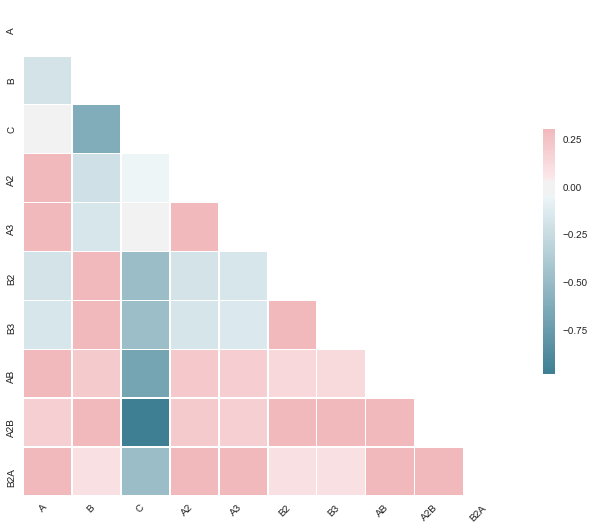

In [289]:
# Check the correlation matrix
sns.set(style="white")
# Compute the correlation matrix after remove columns not designed for correlation calulation
corr = da.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, 
            linewidths=.5, cbar_kws={"shrink": .5}).set_xticklabels(ax.get_xticklabels(),
                                                                    rotation=45,
                                                                    horizontalalignment='right');

In [258]:
train=da.sample(frac=0.7,random_state=200).reset_index(drop=True)
test=da.drop(train.index).reset_index(drop=True)

# Training set
X_train, y_train = train.drop(columns=['C']), train['C']
# Test set
X_test, y_test = test.drop(columns=['C']), test['C']

# data normalization
X_train, X_test = normalization(X_train, X_test)
# add intercept column
X_train = np.concatenate((np.array([np.ones(X_train.shape[0])]).T,X_train),axis = 1)
X_test = np.concatenate((np.array([np.ones(X_test.shape[0])]).T,X_test),axis = 1)

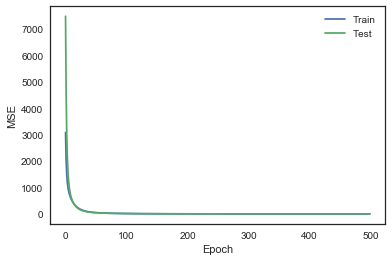

In [259]:
w = BGD(iteration, 10, X_train, y_train, X_test, y_test)

#### This time we can see that the performances on both training and test set are really good!

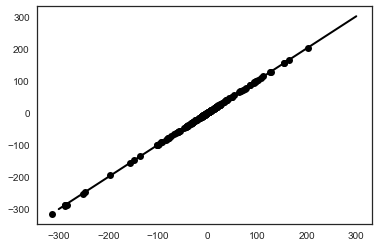

In [260]:
plt.plot(w.dot(X_train.T), y_train, 'o', color='black')
plt.plot([-300, 300], [-300, 300], color='k', linestyle='-', linewidth=2)

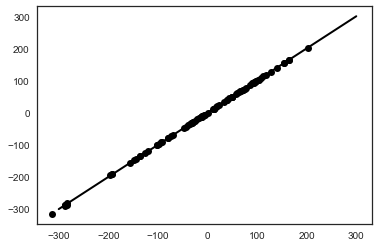

In [261]:
plt.plot(w.dot(X_test.T), y_test, 'o', color='black')
plt.plot([-300, 300], [-300, 300], color='k', linestyle='-', linewidth=2)

In [262]:
print(w)

[-9.37117703e+00  1.12633894e+01 -9.16581770e+00 -4.63937322e-01
  4.34275253e-01 -4.08512507e-01  3.68273984e-01 -6.69023567e-02
 -6.86130069e+01 -1.08904911e-01]
